#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [563]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [564]:

class NaiveBayes:
    def __init__(self, n_bins=200):
        self.priors = {}
        self.likelihoods = {}
        self.bins = None
        self.n_bins = n_bins

    def build_classifier(self, train_features, train_classes):
        self.bins = []
        n_features = train_features.shape[1]
        for i in range(n_features):
            min_val = np.min(train_features[:, i])
            max_val = np.max(train_features[:, i])
            edges = np.linspace(min_val, max_val, num=self.n_bins + 1)
            self.bins.append(edges[1:-1])

        discretized_train = self.data_discretization(train_features)

        classes, counts = np.unique(train_classes, return_counts=True)
        total_samples = len(train_classes)
        self.priors = {c: counts[i] / total_samples for i, c in enumerate(classes)}

        self.likelihoods = {}
        for c in classes:
            mask = (train_classes == c)
            class_samples = discretized_train[mask]
            total_in_class = class_samples.shape[0]

            feature_probs = []
            for i in range(n_features):
                counts = np.bincount(class_samples[:, i], minlength=self.n_bins)
                probs = (counts+1) / (total_in_class + self.n_bins)  # Uwzględniamy n_bins
                feature_probs.append(probs)

            self.likelihoods[c] = np.array(feature_probs)

    def data_discretization(self, data):
        if self.bins is None:
            raise ValueError("Bins not defined. Call build_classifier first.")
        discretized_data = np.zeros_like(data, dtype=int)
        for i in range(data.shape[1]):
            # Zabezpieczenie przed wartościami spoza zakresu
            indices = np.digitize(data[:, i], self.bins[i], right=False)
            indices = np.clip(indices, 0, self.n_bins - 1)  # Przycinanie indeksów
            discretized_data[:, i] = indices
        return discretized_data

    def predict(self, sample):
        discretized_sample = self.data_discretization(sample.reshape(1, -1))[0]
        max_log_prob = -np.inf
        best_class = -1
        for c in self.priors:
            log_prob = math.log(self.priors[c])
            for i in range(len(discretized_sample)):
                b = discretized_sample[i]
                prob = self.likelihoods[c][i][b]
                log_prob += math.log(prob)
            if log_prob > max_log_prob:
                max_log_prob = log_prob
                best_class = c
        return best_class

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}  # Struktura: {klasa: [(mean_1, std_1), (mean_2, std_2), ...]}

    def build_classifier(self, train_features, train_classes):
        self.classes, counts = np.unique(train_classes, return_counts=True)
        total_samples = len(train_classes)
        self.priors = {c: counts[i] / total_samples for i, c in enumerate(self.classes)}
        self.likelihoods = {}

        for c in self.classes:
            mask = (train_classes == c)
            class_data = train_features[mask]
            n_features = class_data.shape[1]
            class_params = []

            for i in range(n_features):
                feature_data = class_data[:, i]
                mean = np.mean(feature_data)
                std = np.std(feature_data)
                if std == 0: std = 1e-9  # Zabezpieczenie przed zerowym odchyleniem
                class_params.append((mean, std))  # Przechowuj parametry w krotce

            self.likelihoods[c] = class_params

    @staticmethod
    def normal_dist(x, mean, std):
        exponent = np.exp(-((x - mean) ** 2) / (2 * (std ** 2)))
        return (1.0 / (np.sqrt(2 * np.pi) * std)) * exponent

    def predict(self, sample):
        max_log_prob = -np.inf
        best_class = -1

        for c in self.classes:
            log_prior = np.log(self.priors[c])
            log_likelihood = 0

            for i in range(len(sample)):
                x_i = sample[i]
                mean, std = self.likelihoods[c][i]  # Pobierz parametry z krotki
                prob = self.normal_dist(x_i, mean, std)
                log_likelihood += np.log(prob)

            total_log_prob = log_prior + log_likelihood
            if total_log_prob > max_log_prob:
                max_log_prob = total_log_prob
                best_class = c

        return best_class

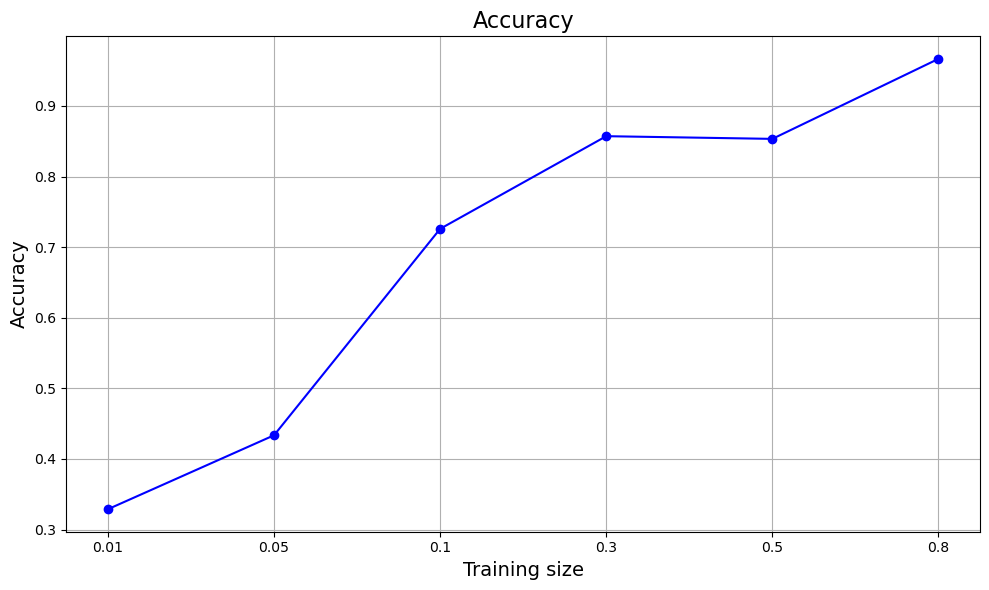

C:\Users\sledz\AppData\Local\Temp\ipykernel_5540\1486045886.py:107: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(prob)


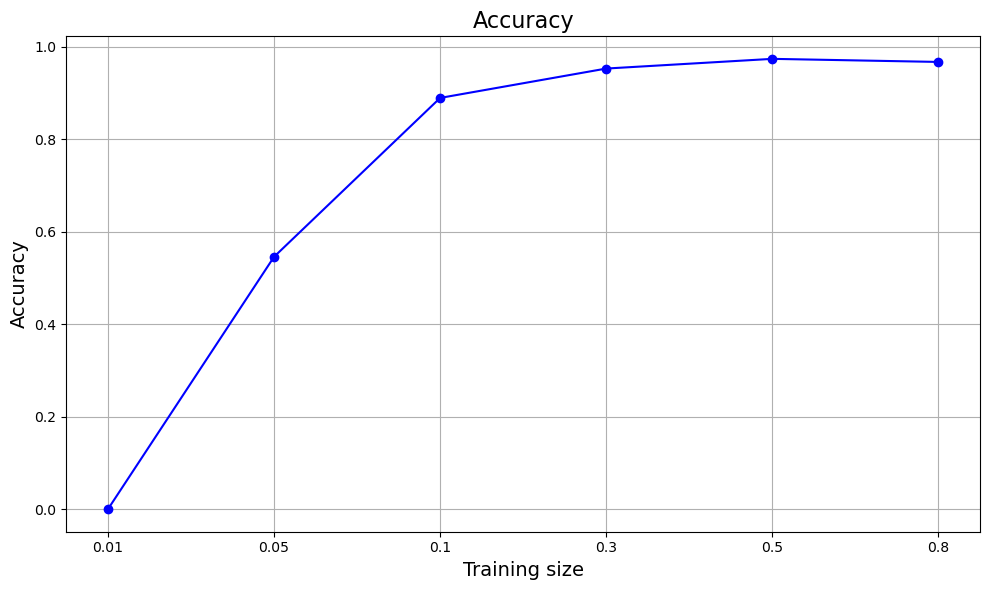

In [565]:
def plot(accuracies, title="Accuracy", x_label="Training size", y_label="Accuracy"):
    # Plot the rewards
    plt.figure(figsize=(10, 6))
    plt.plot(accuracies, color="blue", linestyle="-", marker="o")
    plt.title(title, fontsize=16)
    plt.xticks(np.arange(6), [0.01, 0.05, 0.1, 0.3, 0.5, 0.8])
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test(bayes):
    accuracies = []
    for train_size in [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]:
        correct_predictions = 0
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=123)
        nb = bayes()
        nb.build_classifier(x_train, y_train)
        for sample, correct_cls in zip(x_test, y_test):
            correct_predictions += nb.predict(sample) == correct_cls
        accuracies.append(correct_predictions/len(y_test))
    plot(accuracies=accuracies)

test(NaiveBayes)
test(GaussianNaiveBayes)